# Graph net for node classification

Question: does including the neighborhood provide a benefit over the pairwise classification?

In [1]:
import numpy as np
import torch
import sys

import torch.nn as nn
from torch.optim import Adam, SGD
from torch_cluster import knn_graph
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

from reco.model import DynamicEdgeConvBlock

from reco.training import precision_recall_curve, roc_auc
from reco.loss import GraphClassificationLoss, GraphClassificationLossSingleClass
from reco.datasetPU import TracksterGraph

import torch_geometric.nn as gnn


# TODO: for PU, I trained on 10GeV and evaluated on 5Gev
# Retrain when larger dataset is ready (100E)
ds_name = "CloseByPion200PU"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
def knn_transform(data):
    # pos coordinates are on position 3:6
    data.edge_index = knn_graph(data.pos, k=4, loop=False)
    return data

def prepend_pos(data):
    # GravNet: add S to the front
    data.x = torch.hstack((data.pos, data.x))
    return data

transforms = T.Compose([prepend_pos])

In [4]:
ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=100,
    pileup=True,
    radius=15,
    bigT_e_th=5,
)

In [5]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}, total: {ds_size}")

train_dl = DataLoader(train_set, batch_size=8, shuffle=True)
test_dl = DataLoader(test_set, batch_size=8, shuffle=True)

Train graphs: 6258, Test graphs: 695, total: 6953


In [6]:
class TracksterGraphNet(nn.Module):
    def __init__(self, input_dim, output_dim=2, dropout=0.2):
        super(TracksterGraphNet, self).__init__()

        self.norm = gnn.LayerNorm(input_dim)
        
        hdim1 = 64
        hdim2 = 64

        hdim_fc = 256

        self.edgeconv1 = DynamicEdgeConvBlock(input_dim, hdim1, k=7)
        self.edgeconv2 = DynamicEdgeConvBlock(hdim1, hdim2, k=7)
        # self.edgeconv3 = DynamicEdgeConvBlock(hdim2, hdim3)
        
        # Edge features from node embeddings for classification        
        self.nodenetwork = nn.Sequential(
            nn.Linear(hdim2, hdim_fc),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim_fc, output_dim),
            nn.Sigmoid(),
            # nn.Softmax(dim=1),
        )

    def forward(self, X, batch=None):
        H0 = X #self.norm(X, batch)
        H1 = self.edgeconv1(H0, batch)
        H2 = self.edgeconv2(H1, batch)
        # H3 = self.edgeconv3(H2, batch)
        return self.nodenetwork(H2).squeeze(-1)

In [7]:
def train_graph_classification(model, device, optimizer, loss_func, train_dl):
    train_loss = 0.
    model.train()

    for data in train_dl:
        data = data.to(device)
        optimizer.zero_grad()

        seg_pred = model(data.x, data.batch)
        loss = loss_func(seg_pred, data)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

    return train_loss

In [8]:
@torch.no_grad()
def test_graph_classification(model, device, loss_func, test_dl):
    test_loss = 0.
    model.eval()
    for data in test_dl:
        data = data.to(device)
        seg_pred = model(data.x, data.batch)
        loss = loss_func(seg_pred, data)
        test_loss += loss.item()
    return test_loss

In [9]:
model = TracksterGraphNet(input_dim=ds.data.x.shape[1], output_dim=2)
epochs = 101
model_path = f"models/TracksterGraphNet.ParticleNetLight.ns.{epochs}e-{ds_name}.r{ds.RADIUS}.e{ds.bigT_e_th}.f{ds.N_FILES}.pt"

In [10]:
# %%script echo skipping
# alpha - percentage of negative edges
loss_func = GraphClassificationLoss()

model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)

for epoch in range(epochs):

    train_loss = train_graph_classification(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    scheduler.step()

    if epoch % 5 == 0:
        test_loss = test_graph_classification(model, device, loss_func, test_dl)
        print(
            f"Epoch {epoch}:\t train loss: {train_loss:.3f}\t validation loss: {test_loss:.3f}",
            file=sys.stderr
        )
        
torch.save(model.state_dict(), model_path)
print(model_path)

Epoch 0:	 train loss: 486.103	 validation loss: 40.707
Epoch 1:	 train loss: 405.697	 validation loss: 39.140
Epoch 2:	 train loss: 382.111	 validation loss: 39.171
Epoch 3:	 train loss: 369.180	 validation loss: 40.276
Epoch 4:	 train loss: 351.898	 validation loss: 34.322
Epoch 5:	 train loss: 350.044	 validation loss: 38.644
Epoch 6:	 train loss: 339.794	 validation loss: 35.510
Epoch 7:	 train loss: 333.345	 validation loss: 40.184
Epoch 8:	 train loss: 329.223	 validation loss: 35.060
Epoch 9:	 train loss: 322.568	 validation loss: 34.147
Epoch 10:	 train loss: 320.418	 validation loss: 34.186
Epoch 11:	 train loss: 315.746	 validation loss: 35.371
Epoch 12:	 train loss: 315.689	 validation loss: 37.819
Epoch 13:	 train loss: 309.376	 validation loss: 32.662
Epoch 14:	 train loss: 305.741	 validation loss: 37.744
Epoch 15:	 train loss: 303.640	 validation loss: 32.140
Epoch 16:	 train loss: 300.378	 validation loss: 33.046
Epoch 17:	 train loss: 304.615	 validation loss: 34.898
Ep

In [ ]:
%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

0.4998754359740907


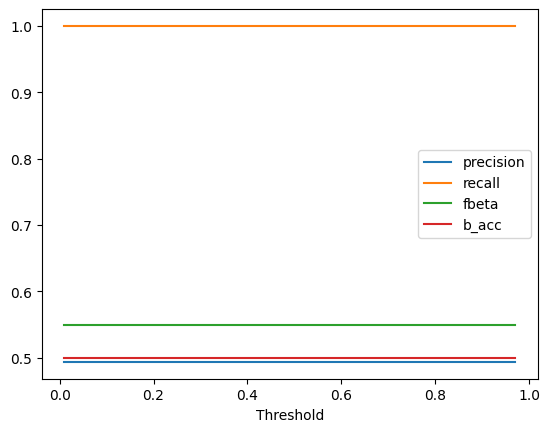

TP: 4345, TN: 0, FP: 4453, FN: 0
TH: 0.01 precision: 0.494 recall: 1.000 fbeta: 0.549 b_acc: 0.500


In [ ]:
#%%script echo skipping - only evaluating foreground
print(roc_auc(model, device, test_dl))
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.5, step=3, truth_threshold=0.5)

## Scoreboard
- 2 layers, 200 files, 0.944

## Eval

Overfit on the training set - need more data!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from reco.data import get_event_data
from reco.evaluation import model_evaluation

file_name = f"{raw_dir}/new_ntuples_15643817_2.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name, pileup=False)

In [ ]:
r_ranges = [3, 5, 10, 15]
results = []

max_events = 20
clue3D_F = []
target_F = []
model_reco_F = []
for r in r_ranges:
    print(f" --- Radius threshold: {r} ---")

    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        model,
        decision_th=0.5,
        radius=r,
        max_events=max_events,
        bigT_e_th=5,
        pileup=True,
        graph=True,
    )
    clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
    target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)
    model_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

 --- Radius threshold: 5 ---
Event 0:
	clue3d_to_sim:	P: 0.988 R: 0.229 F: 0.594
	target_to_sim:	P: 0.997 R: 0.169 F: 0.503
	reco_to_sim:	P: 0.997 R: 0.169 F: 0.503
	|S| = 2 |T| = 1 |R| = 1
Event 1:
	clue3d_to_sim:	P: 1.000 R: 0.283 F: 0.664
	target_to_sim:	P: 1.000 R: 0.197 F: 0.551
	reco_to_sim:	P: 1.000 R: 0.197 F: 0.551
	|S| = 2 |T| = 1 |R| = 1
Event 2:
	clue3d_to_sim:	P: 1.000 R: 0.396 F: 0.766
	target_to_sim:	P: 1.000 R: 0.228 F: 0.596
	reco_to_sim:	P: 1.000 R: 0.228 F: 0.596
	|S| = 2 |T| = 1 |R| = 1
Event 3:
	clue3d_to_sim:	P: 0.995 R: 0.383 F: 0.754
	target_to_sim:	P: 0.999 R: 0.396 F: 0.766
	reco_to_sim:	P: 0.999 R: 0.396 F: 0.766
	|S| = 2 |T| = 1 |R| = 1
Event 4:
	clue3d_to_sim:	P: 0.998 R: 0.250 F: 0.625
	target_to_sim:	P: 0.996 R: 0.347 F: 0.725
	reco_to_sim:	P: 0.996 R: 0.347 F: 0.725
	|S| = 2 |T| = 1 |R| = 1
Event 5:
	clue3d_to_sim:	P: 0.996 R: 0.551 F: 0.858
	target_to_sim:	P: 1.000 R: 0.483 F: 0.824
	reco_to_sim:	P: 1.000 R: 0.483 F: 0.824
	|S| = 2 |T| = 1 |R| = 1
Event

In [ ]:
print(clue3D_F)
print(target_F)
print(model_reco_F)

[0.657833488850464, 0.657833488850464, 0.657833488850464, 0.657833488850464, 0.657833488850464, 0.657833488850464, 0.657833488850464]
[0.6107017213668141, 0.709613324288395, 0.7814183663627319, 0.8552336878770943, 0.8923024450872056, 0.8965497444336143, 0.901496910968999]
[0.6013160111971255, 0.7045536138850059, 0.7699524655659775, 0.8451234492252435, 0.8816242245216624, 0.88365755146593, 0.8875564380144716]


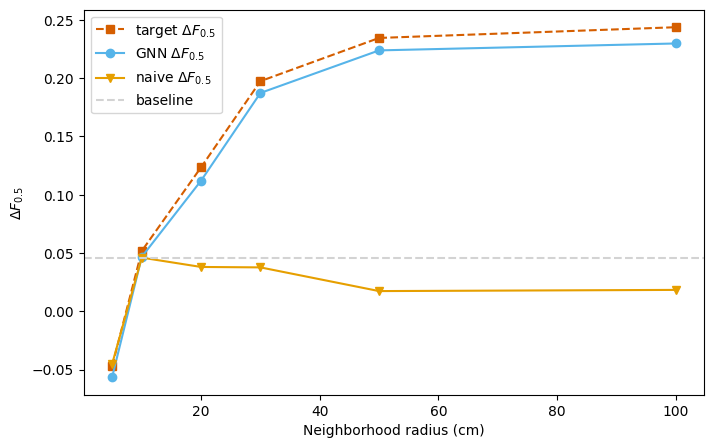

In [20]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

ax.plot(r_ranges[:6], (np.array(target_F) - np.array(clue3D_F))[:6], '--s', label="target", c="#D55E00")
ax.plot(r_ranges[:6], (np.array(model_reco_F) - np.array(clue3D_F))[:6], '-o', label="GNN", c="#56B4E9")
# ax.plot(r_ranges[:6], (np.array(naive_reco_F) - np.array(clue3D_F))[:6], '-v', label="naive", c="#E69F00")

# ax.axhline(max(np.array(naive_reco_F) - np.array(clue3D_F)), label="baseline", c="lightgray", linestyle="--")

ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("$\Delta F_{0.5}$")
# ax.set_ylim((-0.1, 0.1))

# fig.savefig(f'export/{ds_name}-e30-pnetl-graph-radius-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [21]:
print("Reco", max(np.array(model_reco_F) - np.array(clue3D_F)))
print("Naive", max(np.array(naive_reco_F) - np.array(clue3D_F)))
print("Target", max(np.array(target_F) - np.array(clue3D_F)))

Reco 0.2297229491640076
Naive 0.04604952048261768
Target 0.24366342211853498


## Results

Using alpha=balance seems to converge faster (100 epochs rather than 200)
- maybe just sticking to 0.25? (works just fine)

Hyperparams
- (64, 128, noskip), alpha=balance, roc_auc = 0.9733
- (64, 128, 256fc, noskip, 200e), alpha=1-balance, roc_auc = 0.9771
- (64, 128, 256fc, noskip, 200e), alpha=balance, roc_auc = 0.981
- (64, 128, 256fc, noskip, 100e), alpha=0.25, roc_auc = 0.9796